# Project Big Data - Group 22
## Fitbit Analysis Notebook

- Yildiz, Damla 2755457
- Akaçık, Onder 2757404
- Giaj Levra, Federico 2674188

--- 

# Table of Contents
1. [Import data from folder](#datagather)
2. [Daily Activity Analysis](#dailyact)
    1. [Exploratory Data Analysis](#dailyexplo)
3. [Sleep Analysis](#sleep)
4. [Heart Risk Analysis](#heart)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

### Import data from folder <a name="datagather"></a>

In [2]:
path = './Fitabase Data 4.12.16-5.12.16'
paths_list = [
    os.path.join(path, f) for f in os.listdir(path)
    if os.path.isfile(os.path.join(path, f))
]

In [3]:
dataframes = {}
for i, f in enumerate(os.listdir(path)):
    dataframes[f.split('.')[0]] = pd.read_csv(paths_list[i])
dataframes.keys()

dict_keys(['minuteIntensitiesWide_merged', 'dailyActivity_merged', 'sleepDay_merged', 'heartrate_seconds_merged', 'minuteIntensitiesNarrow_merged', 'minuteMETsNarrow_merged', 'hourlySteps_merged', 'hourlyIntensities_merged', 'dailyCalories_merged', 'hourlyCalories_merged', 'minuteSleep_merged', 'minuteCaloriesNarrow_merged', 'dailySteps_merged', 'minuteCaloriesWide_merged', 'minuteStepsNarrow_merged', 'minuteStepsWide_merged', 'weightLogInfo_merged', 'dailyIntensities_merged'])

---

## Daily Activity Analysis <a name="dailyact"></a>

Since `dailyActivity_merged` includes the data we need from `dailyCalories_merged`, `dailyIntensities_merged` and `dailySteps_merged`, we will be using that dataset.

Moreover, for this analysis we will be using `sleepDay_merged` as it allows us to better understand our users and their activity habits.

We will also be adding a column of boolean values which acts as an indicator of whether the date is a weekend or a weekday. This will be useful for later investigations.

In [69]:
df = dataframes['dailyActivity_merged']
df_sleep = dataframes['sleepDay_merged']

df['ActivityDate'] = pd.to_datetime(df['ActivityDate'])
df_sleep['SleepDay'] = pd.to_datetime(df_sleep['SleepDay'])

df['IsWeekend'] = df.ActivityDate.dt.day_name().isin(['Saturday', 'Sunday'])
df_sleep['IsWeekend'] = df_sleep.SleepDay.dt.day_name().isin(
    ['Saturday', 'Sunday'])

### Exploratory Data Analysis <a name="dailyexplo"></a>

We will start by examining the relationship between number of steps taken ('TotalSteps') and the amount of calories burned ('Calories')

<AxesSubplot:xlabel='TotalSteps', ylabel='Calories'>

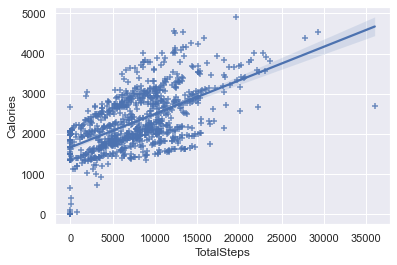

In [9]:
sns.set(rc={'figure.figsize': (13, 7)})
sns.regplot(data=df, x='TotalSteps', y='Calories', color='b', marker='+')

- As expected there is a linear relationship between TotalSteps and Calories. 
- The intercept of the regression line corresponds to the basal metabolic rate which means the amount of calories burned in a day at rest.
- Unexpectedly there are datapoints with Calories value equals to 0. This seems like an outlier since even if you spend your whole day sleeping and being sedentary, you burn calories as much as your basal metabolic rate.

We can look more closely to the datapoints with low Calories values. Total calories burned being less than 1000 is not that [realistic](https://www.hollandandbarrett.com/the-health-hub/weight-management/fitness/exercise/what-is-bmr/)
. Therefore, we can focus on the datapoints with Calories value less than 1000. 

In [70]:
df[df['Calories'] < 1000].head(5)

,Id,ActivityDate,TotalSteps,TotalDistance,TrackerDistance,LoggedActivitiesDistance,VeryActiveDistance,ModeratelyActiveDistance,LightActiveDistance,SedentaryActiveDistance,VeryActiveMinutes,FairlyActiveMinutes,LightlyActiveMinutes,SedentaryMinutes,Calories,IsWeekend,UsedAllDay,Date,ActiveMinutes,day_of_week
30,1503960366,2016-05-12,0,0.00,0.00,0.0,0.00,0.0,0.00,0.0,0,0,0,1440,0,False,True,2016-05-12,0,Thursday
122,1844505072,2016-05-12,0,0.00,0.00,0.0,0.00,0.0,0.00,0.0,0,0,0,711,665,False,False,2016-05-12,0,Thursday
264,2347167796,2016-04-29,42,0.03,0.03,0.0,0.00,0.0,0.03,0.0,0,0,4,2,403,False,False,2016-04-29,4,Friday
345,3977333714,2016-05-11,746,0.50,0.50,0.0,0.37,0.0,0.13,0.0,4,0,9,13,52,False,False,2016-05-11,13,Wednesday
411,4319703577,2016-05-12,17,0.01,0.01,0.0,0.00,0.0,0.01,0.0,0,0,2,0,257,False,False,2016-05-12,2,Thursday


It seems that when the amount of calories burned is less than 1000 the smartwatch is being worn for a limited amount of time.

4 data points has SedentaryMinutes as 1440, which is the whole day, and 0 Calories burned. This is not possible as a person would not sit still all day long. 

In conclusion, these 4 datapoints are outliers and we can remove them from the data frame.

In [71]:
outliers = df[df['Calories'] < 1000][df[df['Calories'] < 1000]
                                     ['SedentaryMinutes'] == 1440]
df_dropped = df.drop(outliers.index)

After removing the outliers we will be analysing the BMR. Moreover we will look into the users which wore the smartwatch whole day.

We accomplish this by adding the following columns: `VeryActiveMinutes`, `FairlyActiveMinutes`, `LightlyActiveMinutes` and `SedentaryMinutes`. 

If their sum is equal to 1440 we can assume 

In [13]:
df['UsedAllDay'] = df[[
    'VeryActiveMinutes', 'FairlyActiveMinutes', 'LightlyActiveMinutes',
    'SedentaryMinutes'
]].aggregate(np.sum, axis=1) == 1440
df_dropped['UsedAllDay'] = df[[
    'VeryActiveMinutes', 'FairlyActiveMinutes', 'LightlyActiveMinutes',
    'SedentaryMinutes'
]].aggregate(np.sum, axis=1) == 1440

Then, let's get the statistics for the days with 0 steps taken and the smartwatch was worn all day.

In [14]:
df_bmr = df_dropped[df_dropped['UsedAllDay']][df_dropped[
    df_dropped['UsedAllDay']]['TotalSteps'] == 0]
df_bmr.head()

,Id,ActivityDate,TotalSteps,TotalDistance,TrackerDistance,LoggedActivitiesDistance,VeryActiveDistance,ModeratelyActiveDistance,LightActiveDistance,SedentaryActiveDistance,VeryActiveMinutes,FairlyActiveMinutes,LightlyActiveMinutes,SedentaryMinutes,Calories,IsWeekend,UsedAllDay
104,1844505072,2016-04-24,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,1440,1347,True,True
105,1844505072,2016-04-25,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,1440,1347,False,True
106,1844505072,2016-04-26,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,1440,1347,False,True
112,1844505072,2016-05-02,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,1440,1348,False,True
117,1844505072,2016-05-07,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,1440,1347,True,True


In [15]:
df_bmr.describe()

,Id,TotalSteps,TotalDistance,TrackerDistance,LoggedActivitiesDistance,VeryActiveDistance,ModeratelyActiveDistance,LightActiveDistance,SedentaryActiveDistance,VeryActiveMinutes,FairlyActiveMinutes,LightlyActiveMinutes,SedentaryMinutes,Calories
count,6.900000e+01,69.0,69.0,69.0,69.0,69.0,69.0,69.0,69.0,69.000000,69.0,69.0,69.000000,69.000000
mean,4.751017e+09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.478261,0.0,0.0,1439.521739,1816.956522
std,2.432003e+09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.972733,0.0,0.0,3.972733,267.239342
min,1.844505e+09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,1407.000000,1347.000000
25%,1.927972e+09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,1440.000000,1688.000000
50%,4.020333e+09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,1440.000000,1841.000000
75%,6.775889e+09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,1440.000000,2017.000000
max,8.792010e+09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,33.000000,0.0,0.0,1440.000000,2664.000000


Seems like there are some datapoints with a non-zero VeryActiveMinutes (Even though 0 steps were taken. That might be because of the form of the activity being different than a regular activity that requires walking, running or etc.). Let's also remove them.

In [16]:
df_bmr = df_bmr[df_bmr['VeryActiveMinutes'] == 0]

In [17]:
df_bmr.describe()[['TotalSteps', 'SedentaryMinutes', 'Calories']]

,TotalSteps,SedentaryMinutes,Calories
count,68.0,68.0,68.000000
mean,0.0,1440.0,1804.500000
std,0.0,0.0,248.226936
min,0.0,1440.0,1347.000000
25%,0.0,1440.0,1688.000000
50%,0.0,1440.0,1841.000000
75%,0.0,1440.0,1990.000000
max,0.0,1440.0,2064.000000


In [18]:
df_bmr.Id.nunique()

12

We have 68 datapoints, coming from 12 distinct users, that are suitable for investigating BMR values. [According to te Holland Barrett](https://www.hollandandbarrett.com/the-health-hub/weight-management/fitness/exercise/what-is-bmr/#:~:text=Men's%20BMR%20tends%20to%20be,the%20day%20at%20complete%20rest.&text=However%2C%20remember%20BMR%20is%20based,around%201550%20calories%20a%20day.), BMR value for men range from 1600 to 1800, while for women it's around 1550. Our BMR values range from 1347 to 2064 with a mean value 1804.5 and standart deviation 248.2. **Using those information, we can deduce for the datapoints used for BMR calculation, the datapoints come from men outnumber the datapoints come from women. However, we should also note down the fact that these values might vary depending ond the individual's physical characteristics.**

Let's go back to the our question "Relationship between number of steps taken ('TotalSteps') and the amount of calories burned ('Calories')". 

In [19]:
X = df_dropped['TotalSteps'].values.reshape((-1, 1))
y = df_dropped['Calories'].values

In [20]:
import numpy as np
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X, y)

print('Model intercept : {}  \nModel coefficients : {}'.format(
    model.intercept_, model.coef_))

Model intercept : 1689.1510000144017  
Model coefficients : [0.08138959]


We could have assumed the model intercept as the BMR value because it corresponds to the number of steps taken being equal to 0. However, it is less than the mean BMR value we investigated, which was 1804.5. That's the case because the data we fitted the linear regression line, include the datapoints that user wore the smartwatch for a certain period of day. Since BMR is calculated for a day, predicting that value using those datapoints is not the proper way.

In [21]:
X_all_day = df_dropped[df_dropped.UsedAllDay]['TotalSteps'].values.reshape(
    (-1, 1))
y_all_day = df_dropped[df_dropped.UsedAllDay]['Calories'].values

In [22]:
model_all_day = LinearRegression()
model_all_day.fit(X_all_day, y_all_day)

print('Model intercept : {}  \nModel coefficients : {}'.format(
    model_all_day.intercept_, model_all_day.coef_))

Model intercept : 1712.6848325918588  
Model coefficients : [0.08111263]


As you can see, the intercept value is a little bit increased and got closer to the mean BMR value, which was 1804.5, we calculated before. However, it's still different than 1804.5. That might be because of the datapoints used come from a broader set of people. Let's check!

In [23]:
df_dropped[df_dropped.UsedAllDay].Id.nunique()

28

Yes! The data of the linear regression line fitted come from 28 distinct people, while the data we used to calculate mean BMR value come from 12 distinct people. Obviously, that's one of the reasons why the intercept, which gives information about the prediction of BMR value, of the regression line we fitted is not equal to the mean BMR value calculated before. Another reason might be intensity of activities might not be directly proportional to the number of steps taken, as we observed a datapoint with 0 steps was taken but still some time was spent and that time is classified as VeryActiveMinutes. And of course, there are other reasons that requires more investigation. 

#### Time spent  and distance taken for each type of activities

There 4 different types of data for the time spent and correspondingly there are 3 different types of data for the distance taken

- `VeryActiveMinutes` , `VeryActiveDistance`
- `FairlyActiveMinutes` , `ModeratelyActiveDistance`
- `VeryLightlyActiveMinutes` , `LightActiveDistance`
- `SedentaryMinutes` , `SedentaryActiveDistance`

Let's investigate the relationship for those corresponding columns.

We can start by fitting 4 different regression lines for each type of activities.

<AxesSubplot:xlabel='SedentaryMinutes', ylabel='SedentaryActiveDistance'>

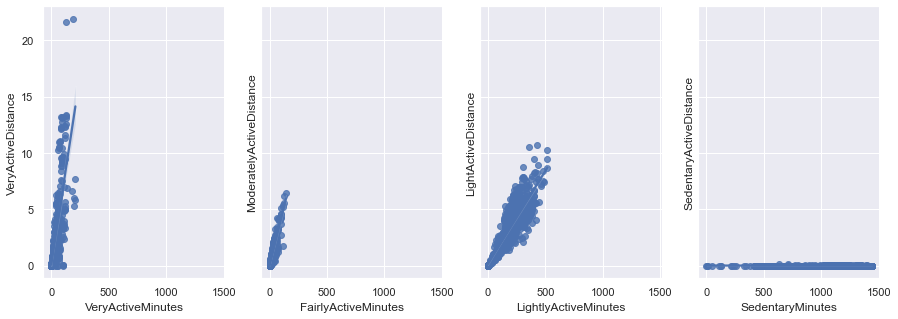

In [24]:
fig, axes = plt.subplots(1, 4, figsize=(15, 5), sharey=True, sharex=True)

sns.regplot(data=df_dropped,
            x='VeryActiveMinutes',
            y='VeryActiveDistance',
            ax=axes[0])

sns.regplot(data=df_dropped,
            x='FairlyActiveMinutes',
            y='ModeratelyActiveDistance',
            ax=axes[1])

sns.regplot(data=df_dropped,
            x='LightlyActiveMinutes',
            y='LightActiveDistance',
            ax=axes[2])

sns.regplot(data=df_dropped,
            x='SedentaryMinutes',
            y='SedentaryActiveDistance',
            ax=axes[3])

Seems like the distance taken for a certain amount of time is greater as the type of the activity gets more active. To be sure, we can fit a linear regressor for each type of activity and then compare the coefficients of the linear regression lines fitted.

In [25]:
# function to get linear regression model parameters
def get_model_params(df, x, y):
    X = df[x].values.reshape((-1, 1))
    y = df[y].values
    model = LinearRegression()
    model.fit(X, y)
    return (model.intercept_, model.coef_)

In [26]:
time_spent_types = [
    'VeryActiveMinutes', 'FairlyActiveMinutes', 'LightlyActiveMinutes',
    'SedentaryMinutes'
]
distance_taken_types = [
    'VeryActiveDistance', 'ModeratelyActiveDistance', 'LightActiveDistance',
    'SedentaryActiveDistance'
]
for t, d in zip(time_spent_types, distance_taken_types):
    intercept, coef = get_model_params(df_dropped, t, d)
    print('{}/{} : \n {:.3f}'.format(d, t, coef[0]))

VeryActiveDistance/VeryActiveMinutes : 
 0.067
ModeratelyActiveDistance/FairlyActiveMinutes : 
 0.042
LightActiveDistance/LightlyActiveMinutes : 
 0.017
SedentaryActiveDistance/SedentaryMinutes : 
 0.000


Yes! The average speed for VeryActiveMinutes is greater than FairlyActiveMinutes and average speed for FairlyActiveMinutes is greater than LightlyActiveMinutes and so on. **Therefore, there is a correletion between type of the activity and average speed for that category. If we had proven the opposite, we would have supported one of our previous claims: 'intensity of activities might not be directly proportional to the number of steps taken', because obviously number of steps taken and distance taken are correlated.**

Actually, that previous claim can be still investigated. The method would be
1. Classifying days by average speed of the day as VeryActiveDay, FairlyActiveDay, LightlyActiveDay and SedentaryDay. 
2. Then, investigating the relationship between total number of steps taken in a day and activity type of a day.
    - it would be better to use the days that smartwatch was worn all day. That way the amount of time for the number of steps taken would same for all datapoints.

However, we won't investigate that claim since we don't need it to justify any of our claims. In a way it's out of the scope of our investigation for now.

#### Total sedentary time on the weekdays and weekends

We can presume that people are more tend to be sedentary on the weekdays, because  lots of jobs require people to work on weekdays and by sitting at their computers. Let's see if that presumption is correct. 

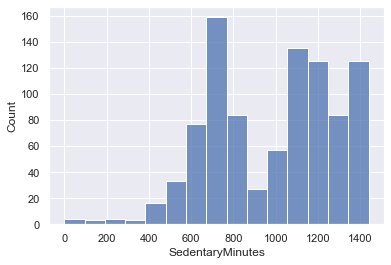

In [27]:
# histogram plot of sedentary minute logs
sns.histplot(data=df_dropped, x='SedentaryMinutes');

Let's plot the sedentary minute logs for weekdays and weekends

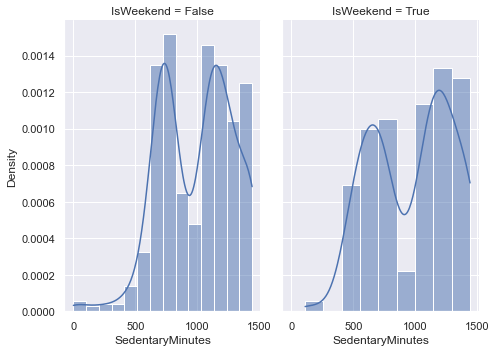

In [28]:
g = sns.FacetGrid(df_dropped, col="IsWeekend", height=5, aspect=.7)
g.map(sns.histplot, "SedentaryMinutes", kde=True,
      stat='density')  # add histogram density regressions for each histogram

It seems like there are two groups of logs, with two different peaks , one around 600 SedentaryMinutes and the other around 1250 SedentaryMinutes. We can create two groups using that information and classify users accordingly.

Let's investigate the average sedentary minutes per user with barplot.

In [29]:
avg_sedentary_minutes = pd.DataFrame(
    df_dropped.groupby('Id').aggregate(np.mean)['SedentaryMinutes'])

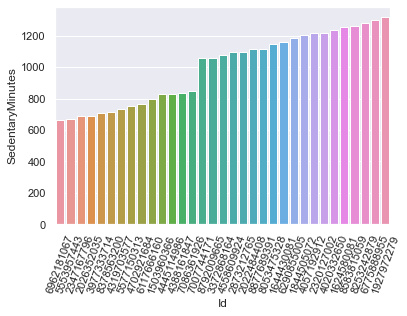

In [30]:
sns.barplot(data=avg_sedentary_minutes,
            x=avg_sedentary_minutes.index,
            y='SedentaryMinutes',
            order=avg_sedentary_minutes.sort_values('SedentaryMinutes').index)
plt.xticks(rotation=70);

Clearly there is a jump after the user with Id: '7086361926'. This point would be nice to classify users into two groups as LessSedentary and MoreSedentary. Also, total average would be nice divide users into two groups. Let's check the total average and see if that criterion correspons to the criterion that we obtained by barplot of individual averages.

In [31]:
total_average = df_dropped['SedentaryMinutes'].aggregate(np.mean)
total_average

989.292735042735

Yes! Dividing to users into two groups by the average would give the same result. Let's do it by adding a column.

In [32]:
df_dropped['MoreSedentary'] = df_dropped.Id.map(
    (avg_sedentary_minutes > total_average)['SedentaryMinutes'])
df_dropped.head()

,Id,ActivityDate,TotalSteps,TotalDistance,TrackerDistance,LoggedActivitiesDistance,VeryActiveDistance,ModeratelyActiveDistance,LightActiveDistance,SedentaryActiveDistance,VeryActiveMinutes,FairlyActiveMinutes,LightlyActiveMinutes,SedentaryMinutes,Calories,IsWeekend,UsedAllDay,MoreSedentary
0,1503960366,2016-04-12,13162,8.50,8.50,0.0,1.88,0.55,6.06,0.0,25,13,328,728,1985,False,False,False
1,1503960366,2016-04-13,10735,6.97,6.97,0.0,1.57,0.69,4.71,0.0,21,19,217,776,1797,False,False,False
2,1503960366,2016-04-14,10460,6.74,6.74,0.0,2.44,0.40,3.91,0.0,30,11,181,1218,1776,False,True,False
3,1503960366,2016-04-15,9762,6.28,6.28,0.0,2.14,1.26,2.83,0.0,29,34,209,726,1745,False,False,False
4,1503960366,2016-04-16,12669,8.16,8.16,0.0,2.71,0.41,5.04,0.0,36,10,221,773,1863,True,False,False


Let's draw boxplot of those 2 groups to see the difference clearly.

<AxesSubplot:xlabel='MoreSedentary', ylabel='SedentaryMinutes'>

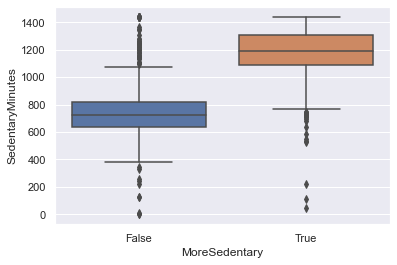

In [33]:
sns.boxplot(x='MoreSedentary', y='SedentaryMinutes', data=df_dropped)

Let's see the behaviour of those 2 groups on the weekdays and weekends.

<AxesSubplot:xlabel='MoreSedentary', ylabel='SedentaryMinutes'>

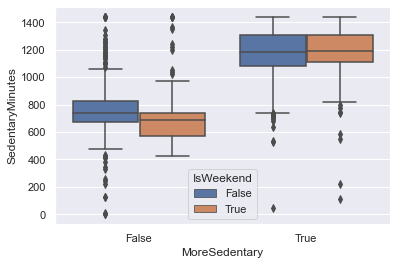

In [34]:
sns.boxplot(x='MoreSedentary',
            y='SedentaryMinutes',
            hue='IsWeekend',
            data=df_dropped)

It seems like for less sedentary group, those users tend to be more sedentary in the weekdays. While the difference for weekdays and weekend for more sedentary group is not that remarkable.

Let's draw the distribution of sedentary minutes logs for less sedentary and more sedentary groups.

- Less sedentary group

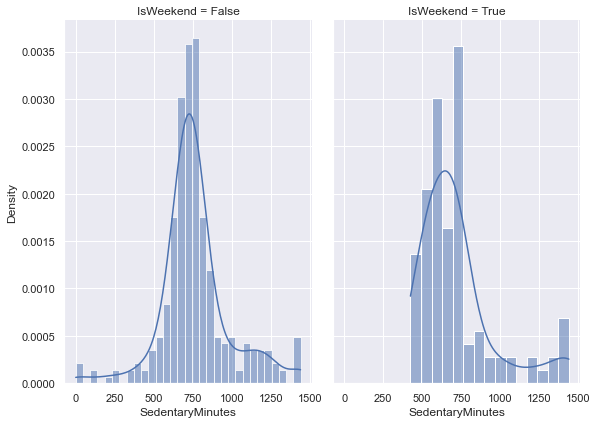

In [35]:
g = sns.FacetGrid(df_dropped[df_dropped['MoreSedentary'] == 0],
                  col="IsWeekend",
                  height=6,
                  aspect=.7)
g.map(sns.histplot, "SedentaryMinutes", kde=True, stat='density');

- More Sedentary

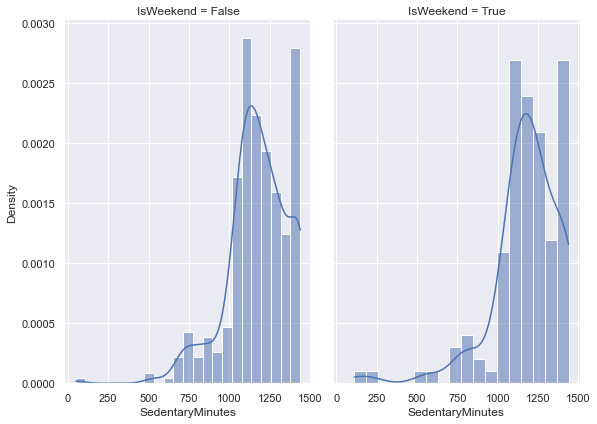

In [36]:
g = sns.FacetGrid(df_dropped[df_dropped['MoreSedentary'] == 1],
                  col="IsWeekend",
                  height=6,
                  aspect=.7)
g.map(sns.histplot, "SedentaryMinutes", kde=True, stat='density');

Again, for the less sedentary group, the distribution is a bit skewed to the lower numbers. Therefore, for this group our presumption in the beggining, that people are tend to be more sedentary in the weekdays, holds. However, for the more sedentary group, there is not a remarkable difference between the distribution for weekdays and weekends.

#### Sleeping habits of less sedentary and more sedentary groups.

We can expect having a different sleeping habits for less sedentary and more sedentary groups. Because, obviously their activeness levels are different.

Let's add MoreSedentary column to df_sleep as well.

In [37]:
df_sleep['MoreSedentary'] = df_sleep.Id.map(
    (avg_sedentary_minutes > total_average)['SedentaryMinutes'])
df_sleep.head()

,Id,SleepDay,TotalSleepRecords,TotalMinutesAsleep,TotalTimeInBed,IsWeekend,MoreSedentary
0,1503960366,2016-04-12,1,327,346,False,False
1,1503960366,2016-04-13,2,384,407,False,False
2,1503960366,2016-04-15,1,412,442,False,False
3,1503960366,2016-04-16,2,340,367,True,False
4,1503960366,2016-04-17,1,700,712,True,False


Then, we can see TotalMinuteAsleep for two groups of being sedentary.

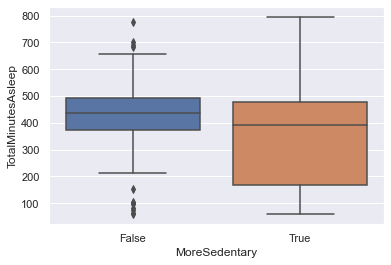

In [38]:
sns.boxplot(x="MoreSedentary", y="TotalMinutesAsleep", data=df_sleep);

Seems like less sedentary group sleeps more on average. Makes sense!

---
## Sleep Analysis <a name="sleep"></a>

In order to better understand sleep habits of fitbit users we will divide them in 4 groups based on [this url](https://www.sleepfoundation.org/how-sleep-works/how-much-sleep-do-we-really-need#:~:text=National%20Sleep%20Foundation%20guidelines1,to%208%20hours%20per%20night) which defines the optimal amount of sleep between 7-9 hours.
- Excess > 9 hours 
- Good 7 - 9 hours
- Deprived < 7




In [39]:
sleepDay = dataframes['sleepDay_merged']
sleepDay['hours'] = sleepDay['TotalMinutesAsleep'] / 60

In [40]:
bins = [sleepDay.hours.min(), 7, 9, sleepDay.hours.max()]

labels = ['deprived', 'good', 'excess']

sleepDay['SleepBins'] = pd.cut(
    sleepDay['hours'],
    bins=bins,
    labels=labels,
    include_lowest=True,
    right=False,
)

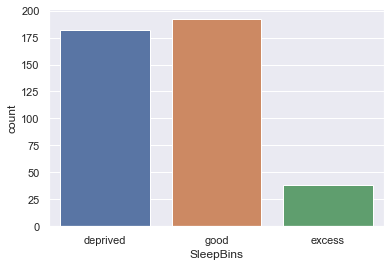

In [41]:
sns.countplot(data=sleepDay, x='SleepBins');

From our binning we can see that the amount of people which have the reccomended amount of sleep is very similar to the amount of people which are sleep deprived, on the other hand, excess sleep seems to be less common.

One would not expect the same amount of sleep deprived people as those who get enough sleep. Therefore we will verify if there are any outliers. 

### Outliers

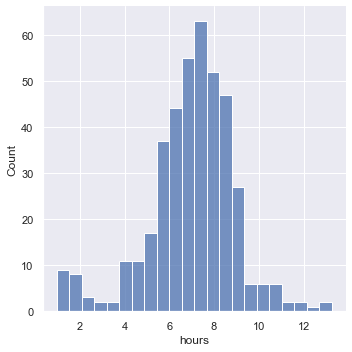

In [42]:
sns.displot(data=sleepDay, x='hours');

- It appears that we have a peak of records which indicate 3 or less hours of sleep. This is unusual in what looks like an otherwise normal distribution. 

- For the next steps we will exclude those which have less than 3 hours of sleep, so we will be looking at "normal" values. 

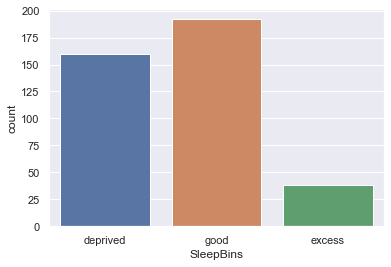

In [43]:
sleepDay = sleepDay[sleepDay['hours'] > 3].copy()
sns.countplot(data=sleepDay, x='SleepBins');

### Collecting the IDs of those which sleep the best

- in order to find those with the best sleep habits, we need to see how many nights with enough sleep they have over all the recorded nights. 
- we will perform some grouping and then pivot the resultin table to gather the required data

In [44]:
sleepPivot = sleepDay.groupby(['Id', 'SleepBins']).agg(
    sleepCount=('SleepBins', 'count')).reset_index().pivot(index='Id',
                                                           columns='SleepBins',
                                                           values='sleepCount')
sleepPivot['goodRatio'] = sleepPivot['good'] / sleepPivot[[
    'deprived', 'good', 'excess'
]].sum(axis=1)

sleepEnhanced = sleepDay.merge(sleepPivot, on='Id')
sleepEnhanced['goodSleeper'] = sleepEnhanced['goodRatio'] >= 0.6

In [45]:
sleepEnhanced.drop_duplicates(subset=['Id']).goodSleeper.value_counts()

False    16
True      5
Name: goodSleeper, dtype: int64

---
This concludes our first part of the analysis. 
We were able to:
- bin users based on the amount of sleep recorded
- detect and exclude outliers with extremely low times of sleep
- find IDs of the users which get enough sleep the most

The last step will allow us to further analyze the data at our disposal

## What are the activity habits of those who sleep the best and the worst?
- we will start our analyses by merging the previously obtained dataset with `dailyActivity_merged`

### Activity correlation

In [46]:
sleepEnhanced['Date'] = pd.to_datetime(sleepEnhanced['SleepDay']).dt.date
dailyActivity = dataframes['dailyActivity_merged']
dailyActivity['Date'] = pd.to_datetime(dailyActivity['ActivityDate']).dt.date
dailyActivity['ActiveMinutes'] = dailyActivity[[
    'VeryActiveMinutes', 'FairlyActiveMinutes', 'LightlyActiveMinutes'
]].sum(axis=1)

In [47]:
sleepEnhanced = sleepEnhanced.merge(
    dataframes['dailyActivity_merged'],
    on=['Id', 'Date'],
)
sleepEnhanced = sleepEnhanced[[
    'Id', 'Date', 'TotalMinutesAsleep', 'TotalTimeInBed', 'hours', 'SleepBins',
    'goodSleeper', 'TotalSteps', 'TotalDistance', 'ActiveMinutes',
    'SedentaryMinutes', 'Calories'
]]

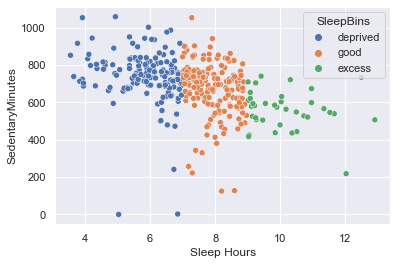

In [48]:
sns.scatterplot(data=sleepEnhanced,
                x='hours',
                y='SedentaryMinutes',
                hue='SleepBins')
plt.xlabel("Sleep Hours");

It appears that the amount of sedentary minutes has some correlation with the amount of hours slept. 

In fact, those which tend to be very sedentary also sleep the least, while those which sleep more than 9 hours are also those which tend to be the least sedentary.

In order to deepen our findings, we will add another dataset which enhances the current one with heart rate data: `heartrate_seconds_merged`

In [49]:
heartData = dataframes['heartrate_seconds_merged']
heartData['Datetime'] = pd.to_datetime(heartData['Time'],
                                       format="%m/%d/%Y %I:%M:%S %p")
heartData = heartData[heartData.Id.isin(sleepEnhanced.Id)].copy()
heartData['Hour'] = heartData['Datetime'].dt.hour + (
    heartData['Datetime'].dt.minute / 60)
heartData['Date'] = heartData['Datetime'].dt.date

In [50]:
bins = [0, 5, 12, 17, 21, 24]

labels = ['night', 'morning', 'day', 'afternoon', 'evening']

heartData['TimeBins'] = pd.cut(
    heartData['Hour'],
    bins=bins,
    labels=labels,
    include_lowest=True,
    right=True,
)

In [51]:
heartData['binMedian'] = heartData.groupby(['Id', 'Date', 'TimeBins'
                                            ])['Value'].transform('median')
heartData = heartData[['Id', 'Date', 'TimeBins',
                       'binMedian']].drop_duplicates()
sleepEnhanced = sleepEnhanced.merge(heartData, on=['Id', 'Date'])

In [52]:
sleepEnhanced

,Id,Date,TotalMinutesAsleep,TotalTimeInBed,hours,SleepBins,goodSleeper,TotalSteps,TotalDistance,ActiveMinutes,SedentaryMinutes,Calories,TimeBins,binMedian
0,2026352035,2016-04-17,437,498,7.283333,good,True,838,0.52,60,1053,1214,morning,68.0
1,2026352035,2016-04-25,506,531,8.433333,good,True,6017,3.73,260,821,1576,morning,98.0
2,2026352035,2016-05-02,511,543,8.516667,good,True,7018,4.35,355,716,1690,afternoon,81.0
3,2026352035,2016-05-02,511,543,8.516667,good,True,7018,4.35,355,716,1690,evening,73.0
4,2026352035,2016-05-09,531,556,8.850000,good,True,10685,6.62,401,543,1869,day,105.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
791,8792009665,2016-05-03,516,545,8.600000,good,False,2421,1.55,156,739,2297,day,76.0
792,8792009665,2016-05-03,516,545,8.600000,good,False,2421,1.55,156,739,2297,afternoon,86.0
793,8792009665,2016-05-03,516,545,8.600000,good,False,2421,1.55,156,739,2297,evening,78.0
794,8792009665,2016-05-04,439,463,7.316667,good,False,2283,1.46,129,848,2067,night,74.0


When grouping hear rates, we took the median value for the hour, as sudden bursts of activity, like using the stairs or inacurracies of the sensor might affect our value

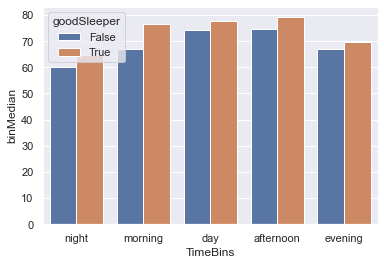

In [53]:
sns.barplot(data=sleepEnhanced,
            x='TimeBins',
            y='binMedian',
            hue='goodSleeper',
            ci=None);

It appears that the median heart rate of good sleepers is higher in every time section of the day

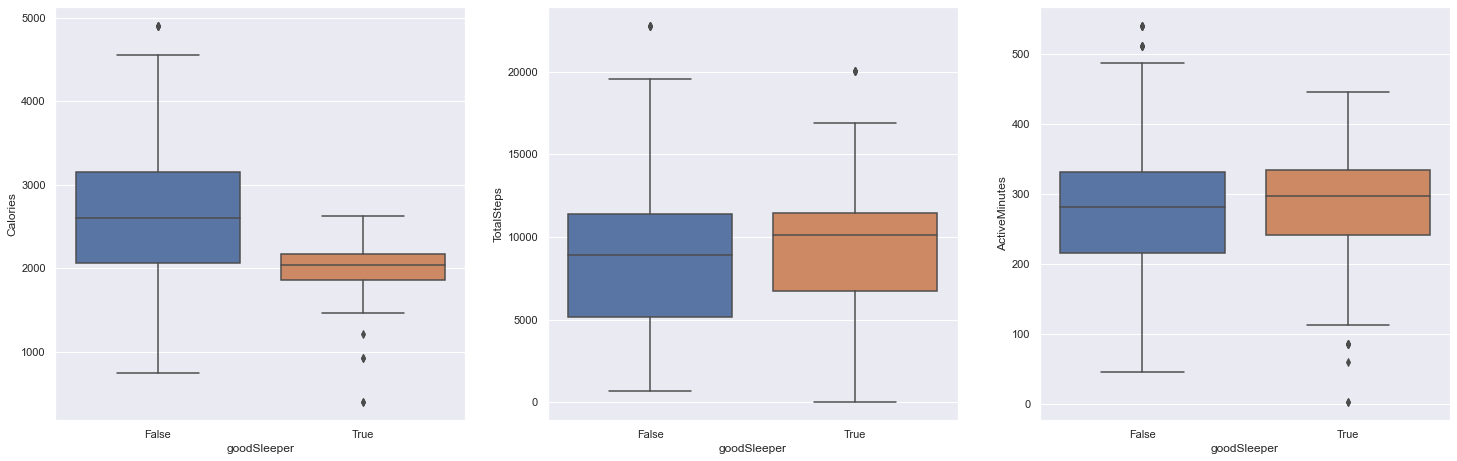

In [54]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(25, 7.6))
sns.boxplot(data=sleepEnhanced, x='goodSleeper', y='Calories', ax=ax1)

sns.boxplot(data=sleepEnhanced, x='goodSleeper', y='TotalSteps', ax=ax2)

sns.boxplot(data=sleepEnhanced, x='goodSleeper', y='ActiveMinutes', ax=ax3);

The three graphs above are able to show some interesting information about the data (in order from left to right):
1. On average good sleepers burn much less calories than the opposite side
2. On average good sleepers walk a little more and the interquartile range is more packed
3. Good sleepers are more active on average, and again the iqr is more packed. In both good and bad sleepers there are outliers in opposite directions, and good sleepers have tighter min-max values

The findings are interestin as they show that those which sleep better do not burn more calories than those who sleep badly. In fact plot 2, 3 show that they are more active but it is shown in plot 1 that the activity must be at a lower intensity. 

## Is there an actionable way of improving sleep quality of those who sleep poorly?

after analyzing the data from the fitbit users it appears that those which do not have good sleeping habits or are experiencing bad sleep should perform lower intensity activities which allow to be active longer. Moreover these activities should be at an intensity level which allows to sustain it for longer without consuming too much energy, thus reducing the burned calories. 

---

#### Investigating correlation between features

<AxesSubplot:>

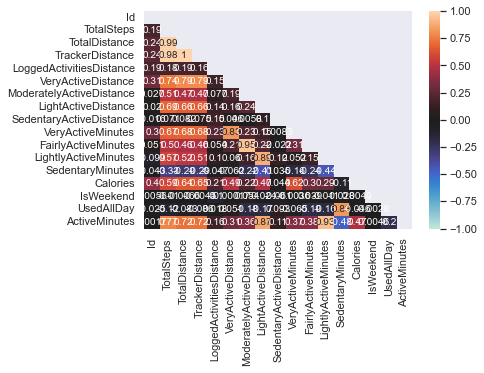

In [55]:
feature_corr = df.corr()
mask = np.zeros_like(feature_corr)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(feature_corr, annot=True, mask=mask, vmin=-1, vmax=1, center=0)

Looking at this graph, there are few interesting findings.


*   Different activity levels don't seem to correlate with each other: we can not say, for example, highly active users are more or less likely to engage in modarete or light leveled activites.
*   Sedentary active minutes are most negatively correlated to light active minutes which means people who exercise hard are more likely to rest more during the rest of the day. 
*   As expected, calories burned are highly correlated to the total distance and total steps, however it seems like light activity distance correlate to calories more strongly than the moderate activity level.  


---

## Heart rate and health risks <a name="heart"></a>

In order to investigate heart rate of users we will use the `heartrate_seconds_merged` dataframe.

We will start by transforming the date information to datetime so we will be able to extract more granular information from it. 

In [56]:
df_heart_rate = dataframes['heartrate_seconds_merged']
df_heart_rate['Time'] = pd.to_datetime(df_heart_rate['Time'],
                                       format="%m/%d/%Y %I:%M:%S %p")
df_heart_rate["Hour"] = df_heart_rate["Time"].dt.hour
df_heart_rate["Date"] = df_heart_rate["Time"].dt.date
df_heart_rate["Weekday"] = df_heart_rate["Time"].dt.day_name()

First, let's see avarage daily heart rate by date and also how it changes with the days of the week. 

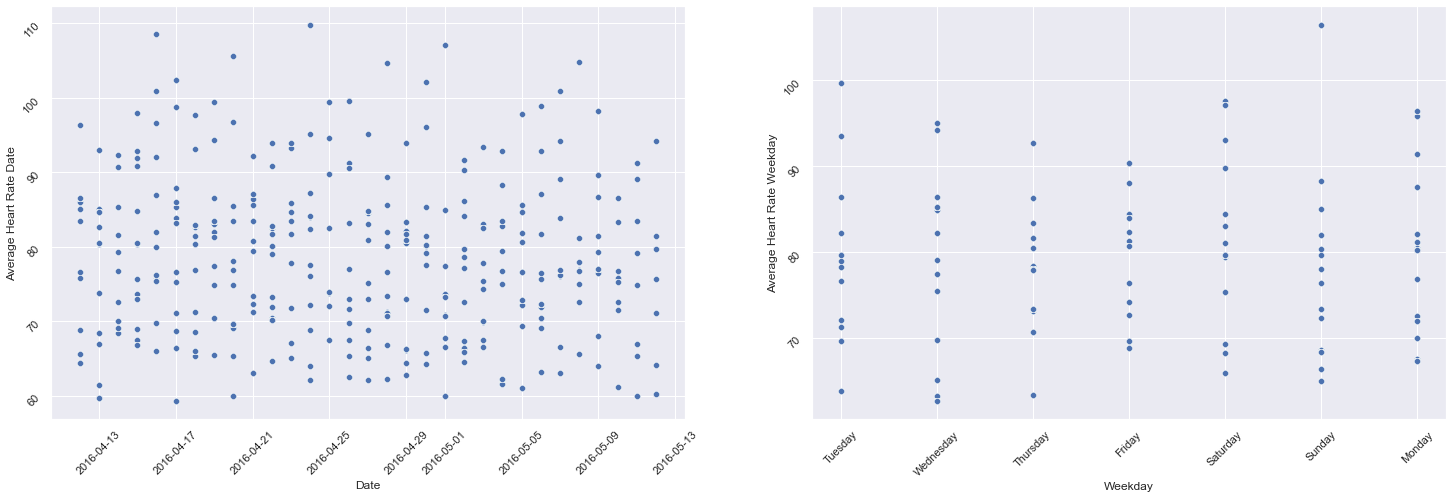

In [57]:
df_heart_rate["Average Heart Rate Date"] = df_heart_rate.groupby(
    ["Id", "Date"])["Value"].transform("mean")
df_heart_rate["Average Heart Rate Weekday"] = df_heart_rate.groupby(
    ["Id", "Weekday"])["Value"].transform("mean")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 7.6))
sns.scatterplot(data=df_heart_rate,
                x="Date",
                y="Average Heart Rate Date",
                ax=ax1)
ax1.tick_params(labelrotation=45);

sns.scatterplot(data=df_heart_rate,
                x="Weekday",
                y="Average Heart Rate Weekday",
                ax=ax2)
ax2.tick_params(labelrotation=45);

The dataset does not contain gender or age of the participants so only way we can identify whether the user has a health risk is through their heart rates. Extrememely low or high heart rates may be an indication of a possible health problem. 

For most of us (adults), between 60 and 100 beats per minute (bpm) is normal. The rate can be affected by factors like stress, anxiety, hormones, medication, and how physically active you are. An athlete or more active person may have a resting heart rate as low as 40 beats per minute ([source](https://www.heart.org/en/healthy-living/fitness/fitness-basics/target-heart-rates)).

So first, let's identify if there is any user with extremely low heart rate.


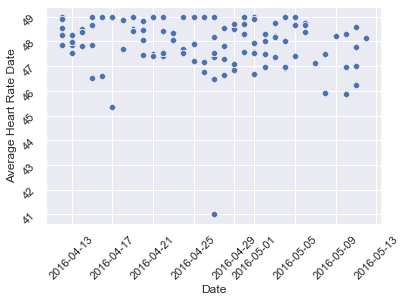

In [58]:
low_heart_rate = df_heart_rate[df_heart_rate["Value"] < 50].copy()

low_heart_rate["Average Heart Rate Date"] = low_heart_rate.groupby(
    ["Id", "Date"])["Value"].transform("mean")

fig, ax = plt.subplots()
fig = sns.scatterplot(data=low_heart_rate,
                      x="Date",
                      y="Average Heart Rate Date")

x_dates = low_heart_rate['Date'].sort_values().unique()
ax.tick_params(labelrotation=45);

Based on this plot, we can see that there is one particular user with a very low avarage heart rate. Let's have a closer look by plotting this participant's heartrate that are fewer than 45bpm.

In [59]:
df_heart_rate.iloc[df_heart_rate['Value'].idxmin()]

Id                                     5577150313
Time                          2016-05-04 02:00:10
Value                                          36
Datetime                      2016-05-04 02:00:10
Hour                                            2
Date                                   2016-05-04
Weekday                                 Wednesday
Average Heart Rate Date                 62.245882
Average Heart Rate Weekday              65.190538
Name: 1504247, dtype: object

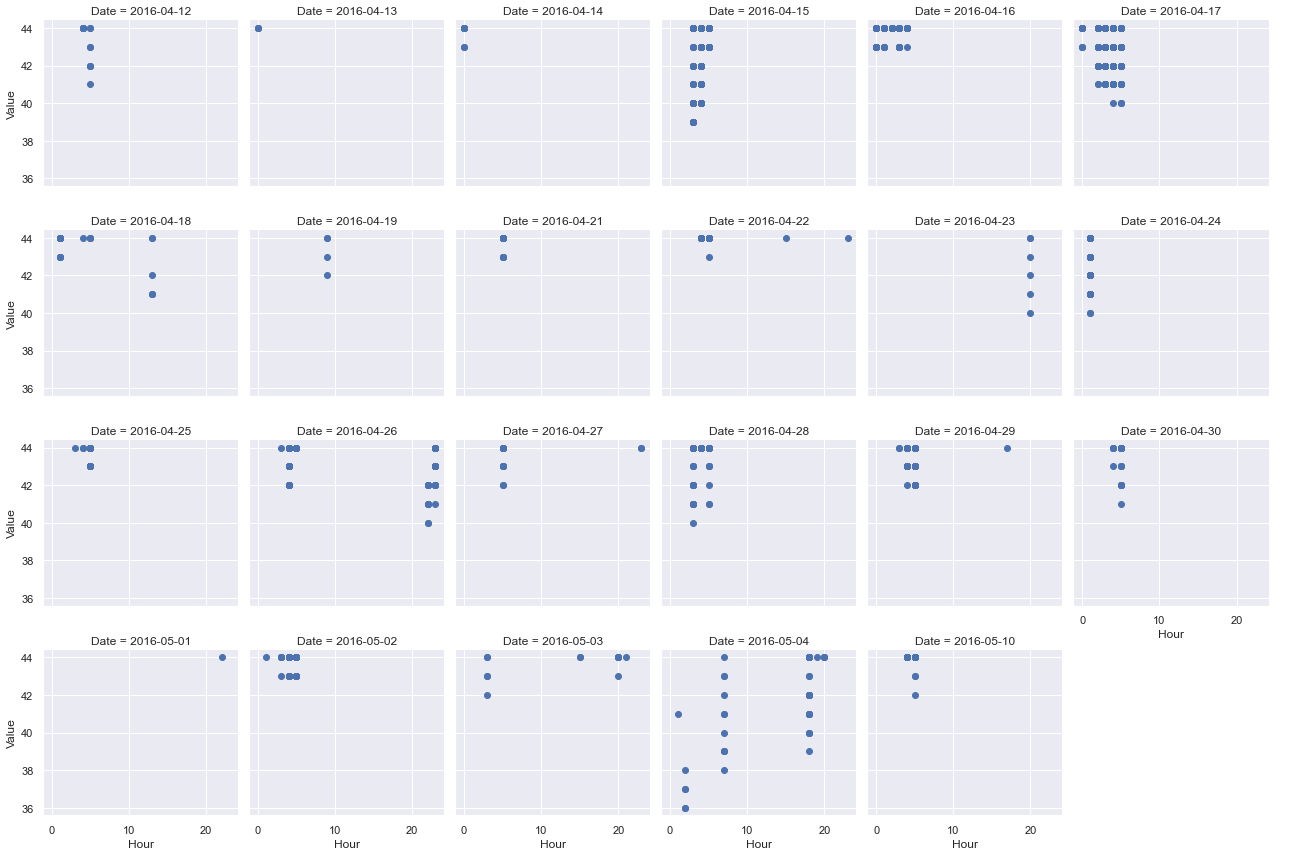

In [60]:
low_heart_rate_user = df_heart_rate[(df_heart_rate["Value"] < 45)
                                    & (df_heart_rate["Id"] == 5577150313)]

graph = sns.FacetGrid(low_heart_rate_user, col="Date", col_wrap=6).add_legend()
graph.map(plt.scatter, "Hour", "Value")
plt.show()

For some cases, user being an athlete may explain relatively low heart rates throughout the day. And since gender, age and health status are unknown, we can not determine the health risks of the user only from this fitbit data. However, it seems the frequency and hours with low heart rate is irregular for this user throughout the month.

#### Exercise amount vs hours and days 

Let's look at which hours users are most active. 

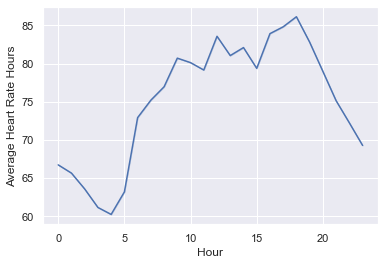

In [61]:
df_heart_rate["Average Heart Rate Hours"] = df_heart_rate.groupby(
    'Hour').Value.transform("mean")
df_heart_rate = df_heart_rate.sort_values(by="Hour")
fig = sns.lineplot(data=df_heart_rate, x="Hour", y="Average Heart Rate Hours")
plt.show()


From this graph, we can see that most of the exercise is done between 16:00-18:00 during the day. And users are mostly inactive during evening between 23:00-05:00.

We will first merge hourly steps and calories dataframes and change the data type of the ActivityHour to datetime to perform calculations.

In [62]:
hourly_steps = dataframes["hourlySteps_merged"]
hourly_calories = dataframes["hourlyCalories_merged"]

hourly_steps['ActivityHour'] = pd.to_datetime(hourly_steps['ActivityHour'])
hourly_calories['ActivityHour'] = pd.to_datetime(
    hourly_calories['ActivityHour'])

hourly_merged = pd.merge(hourly_steps,
                         hourly_calories,
                         on=['ActivityHour', 'Id'])

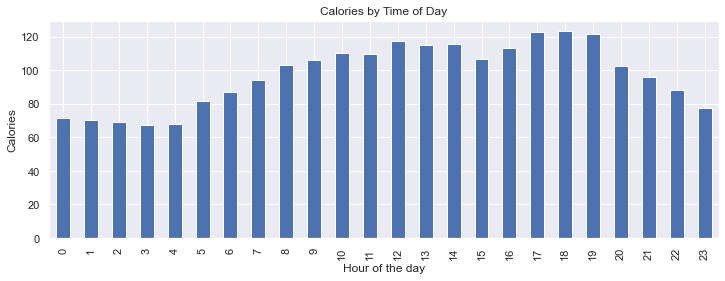

In [63]:
plt.subplots(figsize=(12, 4))
hourly_merged_calories_mean = hourly_merged.groupby(
    hourly_merged['ActivityHour'].dt.hour)['Calories'].mean()
hourly_merged_calories_mean.plot(kind='bar')
plt.xlabel("Hour of the day")
plt.ylabel("Calories")
plt.title('Calories by Time of Day')
plt.show()

From this graph, we can see that users start to become more active between 6 and 8 am. The peak hours seem to occur between 5 and 7 pm, this is probably because people choose to work out after their work/school. And after 8pm, activity levels start decreasing, probably because people go to bed at that time.  


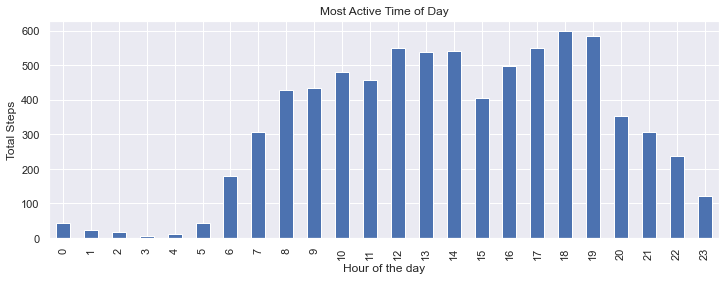

In [64]:
fig, axs = plt.subplots(figsize=(12, 4))
hourly_merged_steps_mean = hourly_merged.groupby(
    hourly_merged['ActivityHour'].dt.hour)['StepTotal'].mean()
hourly_merged_steps_mean.plot(kind='bar')
plt.xlabel("Hour of the day")
plt.ylabel("Total Steps")
plt.title('Most Active Time of Day')
plt.show()

We burn around 50 calories an hour ([source](https://www.sleepfoundation.org/how-sleep-works/how-your-body-uses-calories-while-you-sleep#:~:text=As%20a%20very%20approximate%20number,metabolic%20rate2%20(BMR)) while we sleep and can see that in the graph above. As the users wake up and start exercising, the number of calories burned increases, and peaks around the same time that the users are most active during the day.

Now let's look at which days users are most active.

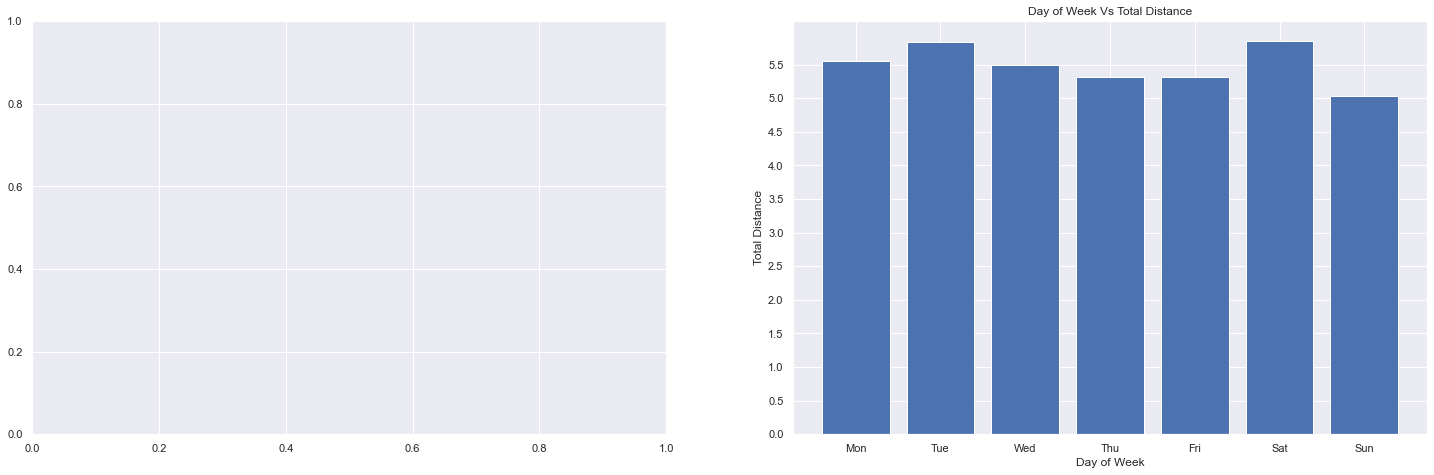

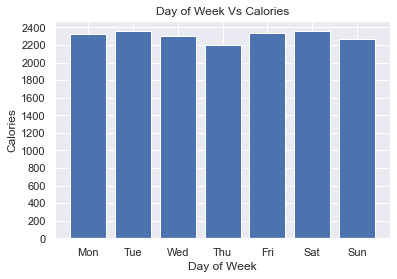

In [65]:
import datetime
import calendar


def findDay(date):
    d = date.weekday()
    return (calendar.day_name[d])


df["day_of_week"] = df["ActivityDate"].apply(findDay)

df_mean = df.pivot_table(values=[
    "TotalDistance", "Calories", "VeryActiveMinutes", "FairlyActiveMinutes",
    "LightlyActiveMinutes", "SedentaryMinutes"
],
                         index="day_of_week",
                         aggfunc='mean')
df_mean.reset_index(inplace=True)

x_day_of_week = df_mean["day_of_week"]
x_day_of_week = x_day_of_week.replace("Monday", 1)
x_day_of_week = x_day_of_week.replace("Tuesday", 2)
x_day_of_week = x_day_of_week.replace("Wednesday", 3)
x_day_of_week = x_day_of_week.replace("Thursday", 4)
x_day_of_week = x_day_of_week.replace("Friday", 5)
x_day_of_week = x_day_of_week.replace("Saturday", 6)
x_day_of_week = x_day_of_week.replace("Sunday", 7)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 7.6))
plt.bar(x_day_of_week, df_mean["TotalDistance"])
plt.title("Day of Week Vs Total Distance")
plt.xlabel("Day of Week")
plt.ylabel("Total Distance")
plt.xticks(ticks=x_day_of_week,
           labels=["Fri", "Mon", "Sat", "Sun", "Thu", "Tue", "Wed"])
plt.yticks(np.arange(0, 6, 0.5))

plt.show()

plt.bar(x_day_of_week, df_mean["Calories"])
plt.title("Day of Week Vs Calories")
plt.xlabel("Day of Week")
plt.ylabel("Calories")
plt.xticks(ticks=x_day_of_week,
           labels=["Fri", "Mon", "Sat", "Sun", "Thu", "Tue", "Wed"])
plt.yticks(np.arange(0, 2600, 200))

plt.show()

From these two plots, we see that users seem a little less motivated to work out on Sundays and Thursdays. But activity level and amount of activity don't change much with differant days of the week. 

#### Predicting number of steps taken

First, we should remove the features that we won't need.

In [66]:
df = df.drop(columns=[
    'Id', 'ActivityDate', 'TrackerDistance', 'LoggedActivitiesDistance',
    'IsWeekend', 'UsedAllDay', 'day_of_week'
])

df.head()

,TotalSteps,TotalDistance,VeryActiveDistance,ModeratelyActiveDistance,LightActiveDistance,SedentaryActiveDistance,VeryActiveMinutes,FairlyActiveMinutes,LightlyActiveMinutes,SedentaryMinutes,Calories,Date,ActiveMinutes
0,13162,8.50,1.88,0.55,6.06,0.0,25,13,328,728,1985,2016-04-12,366
1,10735,6.97,1.57,0.69,4.71,0.0,21,19,217,776,1797,2016-04-13,257
2,10460,6.74,2.44,0.40,3.91,0.0,30,11,181,1218,1776,2016-04-14,222
3,9762,6.28,2.14,1.26,2.83,0.0,29,34,209,726,1745,2016-04-15,272
4,12669,8.16,2.71,0.41,5.04,0.0,36,10,221,773,1863,2016-04-16,267


In [67]:
X = df[df.columns[~df.columns.isin(['TotalSteps'])]]  # input
y = df["TotalSteps"]  # output

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

NameError: name 'train_test_split' is not defined

Let's first fit a simple linear regression model. 

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures

#Getting Polynomials
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X_train)

#Fitting a Linear Regression Model to the data
regressor = LinearRegression()
regressor.fit(X_poly, y_train)

#Prediction
y_pred = regressor.predict(poly.fit_transform(X_test))

print("Root Mean Squared Error is: " +
      str(mean_squared_error(y_test, y_pred, squared=False)))

fig, ax = plt.subplots()
ax.scatter(y_test, y_pred)
ax.plot([y_test.min(), y_test.max()],
        [y_test.min(), y_test.max()],
        'k--',
        lw=2)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

Now a Ridge regression model.

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold

steps = [('poly', PolynomialFeatures(degree=2)), ('scalar', StandardScaler()),
         ('ridge', Ridge())]

ridge_params = {'ridge__alpha': np.linspace(0, 1, 100)}
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

#Fitting a Ridge regression Model to the data
ridge_pipe = Pipeline(steps)
grid_search = GridSearchCV(ridge_pipe, ridge_params, cv=cv)
best = grid_search.fit(X_train, y_train).best_estimator_

#Prediction
y_pred = best.predict(X_test)

print("Root Mean Squared Error is: " +
      str(mean_squared_error(y_test, y_pred, squared=False)))

fig, ax = plt.subplots()
ax.scatter(y_test, y_pred)
ax.plot([y_test.min(), y_test.max()],
        [y_test.min(), y_test.max()],
        'k--',
        lw=2)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

Now Random Forest Regression model. 

In [ ]:
from sklearn.ensemble import RandomForestRegressor

steps = [('poly', PolynomialFeatures(degree=2)), ('scalar', StandardScaler()),
         ('regressor', RandomForestRegressor())]

pipe = Pipeline(steps)
pipe.fit(X_train, y_train)

#Prediction
y_pred = pipe.predict(X_test)

print("Root Mean Squared Error is: " +
      str(mean_squared_error(y_test, y_pred, squared=False)))

fig, ax = plt.subplots()
ax.scatter(y_test, y_pred)
ax.plot([y_test.min(), y_test.max()],
        [y_test.min(), y_test.max()],
        'k--',
        lw=2)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()